In [1]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # we'll need this for sqrt and mean

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
quality = pd.read_csv("quality.csv")
quality.head()

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall,PoorCare
0,1,0,0,18,1,731,10,18,21,93,222,False,0,0
1,2,1,1,6,1,411,0,8,27,19,115,False,1,0
2,3,0,0,5,3,731,10,5,16,27,148,False,5,0
3,4,0,1,19,0,158,34,20,14,59,242,False,0,0
4,5,8,2,19,3,449,10,29,24,51,204,False,0,0


In [3]:
quality.groupby('PoorCare').count()

,MemberID,InpatientDays,ERVisits,OfficeVisits,Narcotics,DaysSinceLastERVisit,Pain,TotalVisits,ProviderCount,MedicalClaims,ClaimLines,StartedOnCombination,AcuteDrugGapSmall
PoorCare,,,,,,,,,,,,,
0,98,98,98,98,98,98,98,98,98,98,98,98,98
1,33,33,33,33,33,33,33,33,33,33,33,33,33


The baseline model has the accuracy of

In [4]:
98/(98+33)

0.7480916030534351

We need to randomly split our data into the test and train set. For now, I'll use python's random number generator. Ideally, we want the same rows as in R, but I'll only implement this when I know how to run R from Python.

In [5]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(quality, train_size=0.75, random_state=1)

qualityTrain = pd.DataFrame(train, columns=quality.columns)
qualityTest = pd.DataFrame(test, columns=quality.columns)

In [6]:
qualityTrain['PoorCare'] = qualityTrain['PoorCare'].astype(int)

In [7]:
import statsmodels.api as sm
qualityTrain

cols = ['OfficeVisits', 'Narcotics']
x = qualityTrain[cols]
x = sm.add_constant(x)
y = qualityTrain['PoorCare']

model = sm.Logit(y, x.astype(float)).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.405241
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               PoorCare   No. Observations:                   98
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            2
Date:                Wed, 25 Mar 2015   Pseudo R-squ.:                  0.2390
Time:                        17:52:11   Log-Likelihood:                -39.714
converged:                       True   LL-Null:                       -52.188
                                        LLR p-value:                 3.823e-06
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -2.7718      0.561     -4.940      0.000        -3.872    -1.672
OfficeVisits     0.0680      0.031      2.211      0.027         0.008     0.128
Narcotics        0.1223      0.041      2.991      0.003         0.042     0.203
================================================================================
"""

In [21]:
x = qualityTest[cols]
x = sm.add_constant(x)

predTest = model.predict(x.astype(float))

In [22]:
x = qualityTrain[cols]
x = sm.add_constant(x)

predTrain = model.predict(x.astype(float))

###Specificity and selectivity
Now that we built the model, we can check its specificity and sensitivity. They are defined by:

$$\mathrm{sensitivity= \frac{TP}{TP+FN}}$$
$$\mathrm{specificity= \frac{TN}{TN+FP}}$$


In [47]:
pd.crosstab(qualityTrain['PoorCare'], predTrain > 0.2, colnames=['PredictedCare'])

PredictedCare,False,True
PoorCare,,
0,60,16
1,8,14


In [50]:
sens = 14/(14+8)
spec  = 60/(60+16)
print(sens)
print(spec)

0.6363636363636364
0.7894736842105263


Increase the threshold to 0.7:

In [46]:
pd.crosstab(qualityTrain['PoorCare'], predTrain > 0.7, colnames=['PredictedCare'])

PredictedCare,False,True
PoorCare,,
0,75,1
1,15,7


In [51]:
sens = 7/(7+8)
spec  = 75/(75+1)
print(sens)
print(spec)

0.4666666666666667
0.9868421052631579


###Receiver Operating Characteristic (ROC) curve

Python has a way to do this painlessly, horray!
Docs: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

In [81]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(qualityTrain['PoorCare'], predTrain)

In [82]:
fpr

array([ 0.        ,  0.        ,  0.01315789,  0.01315789,  0.01315789,
        0.01315789,  0.01315789,  0.01315789,  0.01315789,  0.01315789,
        0.01315789,  0.02631579,  0.02631579,  0.02631579,  0.03947368,
        0.05263158,  0.06578947,  0.06578947,  0.07894737,  0.09210526,
        0.10526316,  0.11842105,  0.13157895,  0.14473684,  0.14473684,
        0.15789474,  0.17105263,  0.18421053,  0.21052632,  0.22368421,
        0.25      ,  0.26315789,  0.27631579,  0.28947368,  0.30263158,
        0.31578947,  0.32894737,  0.34210526,  0.38157895,  0.40789474,
        0.43421053,  0.43421053,  0.44736842,  0.46052632,  0.5       ,
        0.51315789,  0.52631579,  0.56578947,  0.59210526,  0.60526316,
        0.63157895,  0.63157895,  0.68421053,  0.71052632,  0.71052632,
        0.78947368,  0.80263158,  0.85526316,  0.88157895,  0.92105263,
        0.93421053,  0.94736842,  0.96052632,  0.98684211,  1.        ])

In [83]:
thresholds

array([ 0.99825993,  0.99029596,  0.9564465 ,  0.91436947,  0.85609767,
        0.79840602,  0.78711261,  0.77548717,  0.64637286,  0.58866208,
        0.56803056,  0.42671673,  0.38708926,  0.35235367,  0.30713202,
        0.29599309,  0.28746985,  0.26844018,  0.26041686,  0.25777721,
        0.25528894,  0.25241765,  0.23992247,  0.23755139,  0.23028563,
        0.21844547,  0.21610694,  0.21148445,  0.20480181,  0.19610044,
        0.19394177,  0.18559412,  0.17552778,  0.17542589,  0.1658962 ,
        0.16400218,  0.16212558,  0.15488423,  0.14790922,  0.14111047,
        0.13953665,  0.13156483,  0.13000168,  0.12845435,  0.12398283,
        0.12249706,  0.11957144,  0.11536821,  0.112591  ,  0.10860288,
        0.10727884,  0.10596903,  0.10345694,  0.10218845,  0.10093376,
        0.09731327,  0.09611203,  0.0914972 ,  0.08923667,  0.08599562,
        0.08079542,  0.07397738,  0.07034264,  0.06687358,  0.05886525])

In [84]:
tpr

array([ 0.04545455,  0.09090909,  0.09090909,  0.13636364,  0.18181818,
        0.22727273,  0.27272727,  0.31818182,  0.36363636,  0.40909091,
        0.45454545,  0.45454545,  0.5       ,  0.54545455,  0.54545455,
        0.54545455,  0.54545455,  0.59090909,  0.59090909,  0.59090909,
        0.59090909,  0.59090909,  0.59090909,  0.59090909,  0.63636364,
        0.63636364,  0.63636364,  0.63636364,  0.63636364,  0.63636364,
        0.63636364,  0.63636364,  0.63636364,  0.63636364,  0.63636364,
        0.63636364,  0.63636364,  0.72727273,  0.72727273,  0.72727273,
        0.72727273,  0.77272727,  0.77272727,  0.77272727,  0.77272727,
        0.77272727,  0.77272727,  0.77272727,  0.77272727,  0.77272727,
        0.81818182,  0.86363636,  0.90909091,  0.90909091,  0.95454545,
        0.95454545,  0.95454545,  0.95454545,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ])

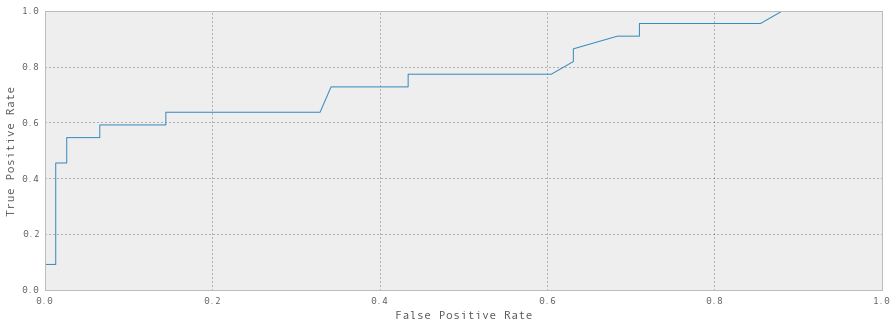

In [88]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(fpr, tpr)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")

###Area under ROC curve (AUC)